# UE Patient Numérique | Projet
### Segmentation multi-organes en modalité IRM abdominale

pierre-henri.conze@imt-atlantique.fr, francoi.rousseau@imt-atlantique.fr, arnaud.boutillon@imt-atlantique.fr

---

L'objectif de ce projet est de développer un **modèle de segmentation multi-organes** (foie, reins et rate) à partir d'images IRM T2 abdominales. 

Les données sont disponibles sur Moodle. Vous disposez de **12 examens**, 8 pour l'apprentissage et 4 pour le test.

Veuillez au préalable importer dans l'espace de stockage de la session Colab les images fournies.

### 1 - Gestion des données 

La fonction read_train_exam(exam_nb) fournie ci-dessous permets de lire pour un examen d'apprentissage d'indice exam_nb :
- l'image acquise en modalité T2
- un masque de segmentation vérité-terrain (1 : foie, 2 : rein droit, 3 : rein gauche, 4 : rate)

La fonction read_test_exam(exam_nb) permets de lire l'image T2 correspondant à l'examen de test d'indice exam_nb.

In [1]:
import nibabel

def read_train_exam(exam_nb):
    image = nibabel.load('%02d-T2SPIR-src.nii.gz'%(exam_nb))
    mask = nibabel.load('%02d-T2SPIR-mask.nii.gz'%(exam_nb))
    return image, mask

def read_test_exam(exam_nb):
    image = nibabel.load('%02d-T2SPIR-src.nii.gz'%(exam_nb))
    return image

Les examens 1, 2, 3, 5, 8, 10, 13 et 19 serviront d'examens d'apprentissage tandis que les examens 21, 22, 32 et 39 serviront d'examens de test. Les masques associés aux examens d'apprentissage sont fournis. Les masques associés aux examens de test seront fournis à la fin du projet (début de séance 11), pour évaluation.

In [2]:
train_ids = [1,2,3,5,8,10,13,19]
test_ids = [21,22,32,39]

Visualisons les examens d'apprentissage.

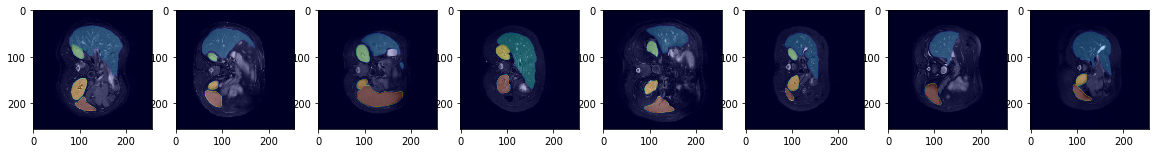

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

img_slices, mask_slices = [], []
for train_id in train_ids:
    image, mask = read_train_exam(train_id)
    a = np.unique(np.where(mask.get_fdata()>0.)[2])
    z = a[np.int(1*len(a)/2)]
    img_slices.append(resize(image.get_fdata()[:,:,z],(256,256),mode='reflect',anti_aliasing=True))
    mask_slices.append(resize(mask.get_fdata()[:,:,z],(256,256),mode='reflect',anti_aliasing=True))

plt.figure(figsize=(20, 15))
for i in range(len(train_ids)):
    plt.subplot(1, len(train_ids), i+1)
    plt.imshow(img_slices[i], cmap='gray', interpolation='nearest')
    plt.imshow(mask_slices[i], cmap='jet', alpha=0.3)
plt.show()

Pendant vos expérimentations, des examens d'apprentissage peuvent être utilisés comme données de test pour valider les modèles obtenus.

In [4]:
test_id_1, test_id_2 = 13, 19
slice_1, slice_2 = 13, 13
image_1, mask_1 = read_train_exam(test_id_1)
image_2, mask_2 = read_train_exam(test_id_2)
slice_im_1 = image_1.get_fdata()[:,:,slice_1]
slice_im_2 = image_2.get_fdata()[:,:,slice_2]
slice_mask_1 = mask_1.get_fdata()[:,:,slice_1].astype(np.uint8)
slice_mask_2 = mask_2.get_fdata()[:,:,slice_2].astype(np.uint8)


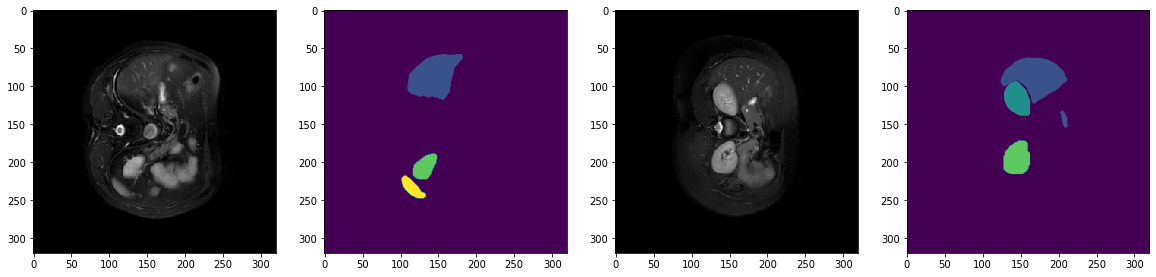

In [5]:
plt.figure(figsize=(20, 15))
plt.subplot(1, 4, 1)
plt.imshow(slice_im_1, cmap='gray', interpolation='nearest')
plt.subplot(1, 4, 2)
plt.imshow(slice_mask_1,vmin=0,vmax=4)
plt.subplot(1, 4, 3)
plt.imshow(slice_im_2, cmap='gray', interpolation='nearest')
plt.subplot(1, 4, 4)
plt.imshow(slice_mask_2,vmin=0,vmax=4)
plt.show()

### 2 - Baseline

Prenons l'approche par apprentissage statistique du TP I-3. 

**Déformation d'image** : 

On définit deux fonctions pour découper l'image et le masque en "slices" et puis appliquer méthode "slic" pour calculer des supervoxels

*Visualiser comment la slic fonctionne*

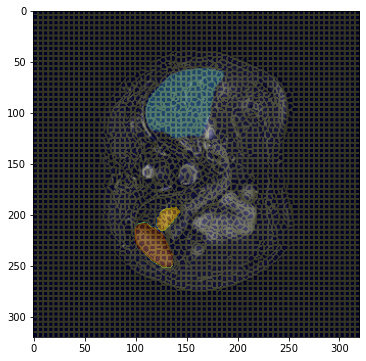

In [6]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
segment_slic = slic(image_1.get_fdata()[:,:,15],4000,100)
boundaries = mark_boundaries(segment_slic,segment_slic)

plt.figure(figsize=(10,6))
plt.imshow(image_1.get_fdata()[:,:,14], cmap='gray')
plt.imshow(boundaries, cmap='jet', alpha=0.3)
plt.imshow(mask_1.get_fdata()[:,:,14], cmap='jet', alpha=0.3)
plt.show()

*Les deux fonctions : decoupage (pour déformer l'image 3D en plusieurs coupes 2D en supervoxels) et decoupage_mask (pour découper le masque correspondant)*

In [7]:
from skimage.restoration import denoise_tv_bregman

def decoupage(image, nb_segments, compactness, sigma):
    slice_ = []
    for i in range(image.shape[2]):
        img = image.get_fdata()[:,:,i]
        image_slic = np.copy(img)
        segments_slic = slic(img, n_segments=nb_segments, compactness=compactness, sigma=sigma, multichannel=False)
        for idx in range(len(np.unique(segments_slic))):
            orig_pixel = img[np.where(segments_slic == idx)]
            avg = np.mean(orig_pixel)
            image_slic[np.where(segments_slic == idx)] = avg
        slice_.append(image_slic)
    return slice_

def decoupage_mask(mask):
    slice_ = []
    for i in range(mask.shape[2]):
        slice_.append(mask.get_fdata()[:,:,i])
    return slice_

*Visualiser les résultats des deux fonctions ci-dessus*

In [8]:
test = decoupage(image_1,4000,100,0)
test_mask = decoupage_mask(mask_1)
print(test[0].flatten().shape)
print(len(test))

(102400,)
30


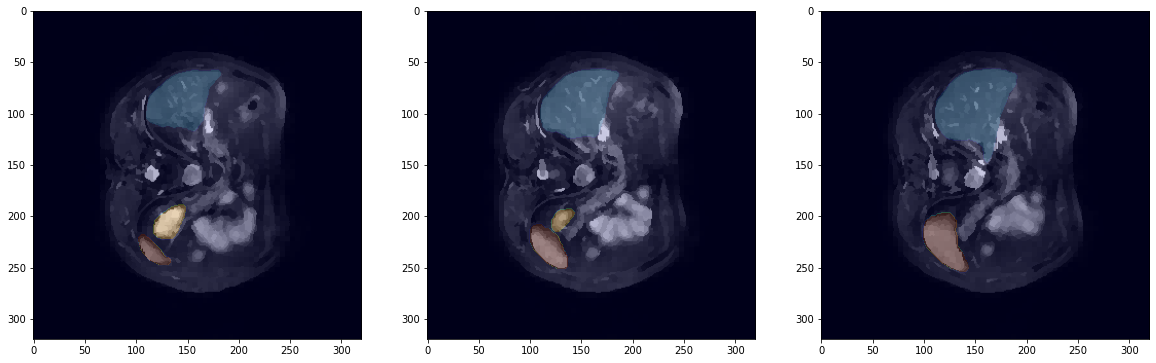

In [10]:
plt.figure(figsize=(20, 15))
for i in range(1,4):
    plt.subplot(1, 3, i)
    plt.imshow(test[i+12], cmap='gray')
    plt.imshow(test_mask[i+12], cmap='jet', alpha=0.2)
plt.show()

**Le calcul de descripteurs**

On définit une fonctions exam2vec pour calculer une matrice comprenant des descripteurs d'une image 3D (en fait ce sont les descripteurs des coupes 2D d'une image 3D) et son masque correspondant

In [11]:
def exam2vec(image, mask, nb_segments, compactness, sigma):
    image_slices = decoupage(image, nb_segments, compactness, sigma)
    for idx, slice_ in enumerate(image_slices):
        vec_img = slice_.flatten()
        vec_tvb = denoise_tv_bregman(slice_,weight=1.0).flatten()
        data_slice = np.column_stack((vec_img,vec_tvb))
        if idx == 0:
            data = data_slice
        else:
            data = np.concatenate((data,data_slice), axis=0)
    (X,Y,Z) = np.where(np.ones(shape=image.shape,dtype=np.bool))
    X = np.array(X, dtype=np.float)/image.shape[0]
    Y = np.array(Y, dtype=np.float)/image.shape[1]
    Z = np.array(Z, dtype=np.float)/image.shape[2]
    data = np.concatenate((data,X.reshape(-1,1),Y.reshape(-1,1),Z.reshape(-1,1)), axis=1)
    if mask is not None:
        mask_slices = decoupage_mask(mask)
        for idx, slice_ in enumerate(mask_slices):
            mask_slice = slice_.flatten()
            if idx == 0:
                vec_mask = mask_slice
            else:
                vec_mask = np.concatenate((vec_mask,mask_slice), axis=0)
        return data, vec_mask
    else:
        return data

*Faire l'entraînement sur l'ensemble des images 1, 2, 3, 5, 8, 10, 13 et 19 avec le meilleur couple des paramètres (n_segments=4000 et compactness=100)*

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

nb_segments = 4000
compactness = 100
sigma = 0

for idx, train_id in enumerate(train_ids):
    image, mask = read_train_exam(train_id)
    data, vec_mask = exam2vec(image, mask, nb_segments, compactness, sigma)
    if idx > 0:
        train_data = np.concatenate((train_data, data),axis=0)
        train_mask = np.concatenate((train_mask, vec_mask),axis=0)
    else:
        train_data = data
        train_mask = vec_mask

scaler = StandardScaler()
scaler.fit(train_data)
scaler.transform(train_data)  

clf = RandomForestClassifier(n_estimators=20, random_state=0)
clf.fit(train_data, train_mask)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

*Faire la prédiction sur les deux images 13 et 19 pour valider le fonctionnement du modèle entraîné*

In [13]:
image_1, mask_1 = read_train_exam(test_id_1)
data = exam2vec(image_1, None, nb_segments, compactness, sigma)
scaler.transform(data)
estimation_1 = clf.predict(data)
seg_1_reshape = np.reshape(estimation_1, (image_1.get_fdata().shape[2],image_1.get_fdata().shape[0]*image_1.get_fdata().shape[1]))
seg_1_2Ds = []
for i in range(seg_1_reshape.shape[0]):
    seg_1_2Ds.append(np.reshape(seg_1_reshape[i,:], (image_1.get_fdata().shape[0],image_1.get_fdata().shape[1])))
seg_1 = np.stack(seg_1_2Ds, axis=2)
print(seg_1.shape)

(320, 320, 30)


In [14]:
image_2, mask_2 = read_train_exam(test_id_2)
data = exam2vec(image_2, None, nb_segments, compactness, sigma)
scaler.transform(data)
estimation_2 = clf.predict(data)
seg_2_reshape = np.reshape(estimation_2, (image_2.get_fdata().shape[2],image_2.get_fdata().shape[0]*image_2.get_fdata().shape[1]))
seg_2_2Ds = []
for i in range(seg_2_reshape.shape[0]):
    seg_2_2Ds.append(np.reshape(seg_2_reshape[i,:], (image_2.get_fdata().shape[0],image_2.get_fdata().shape[1])))
seg_2 = np.stack(seg_2_2Ds, axis=2)
print(seg_2.shape)

(320, 320, 30)


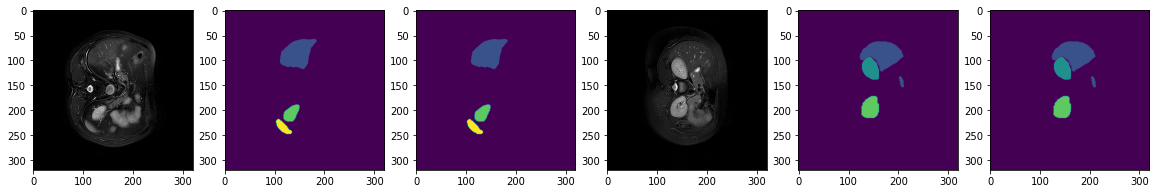

In [15]:
slice_seg_1 = seg_1[:,:,slice_1].astype(np.uint8)
slice_seg_2 = seg_2[:,:,slice_2].astype(np.uint8)
plt.figure(figsize=(20, 15))
plt.subplot(1, 6, 1)
plt.imshow(slice_im_1, cmap='gray', interpolation='nearest')
plt.subplot(1, 6, 2)
plt.imshow(slice_mask_1,vmin=0,vmax=4)
plt.subplot(1, 6, 3)
plt.imshow(slice_seg_1,vmin=0,vmax=4)
plt.subplot(1, 6, 4)
plt.imshow(slice_im_2, cmap='gray', interpolation='nearest')
plt.subplot(1, 6, 5)
plt.imshow(slice_mask_2,vmin=0,vmax=4)
plt.subplot(1, 6, 6)
plt.imshow(slice_seg_2,vmin=0,vmax=4)
plt.show()

*Faire la prédiction sur les images de l'ensemble de test*

In [16]:
image_test_1 = read_test_exam(test_ids[0])
data = exam2vec(image_test_1, None, nb_segments, compactness, sigma)
scaler.transform(data)
estimation_t1 = clf.predict(data)
seg_t1_reshape = np.reshape(estimation_t1, (image_test_1.get_fdata().shape[2],image_test_1.get_fdata().shape[0]*image_test_1.get_fdata().shape[1]))
seg_t1_2Ds = []
for i in range(seg_t1_reshape.shape[0]):
    seg_t1_2Ds.append(np.reshape(seg_t1_reshape[i,:], (image_test_1.get_fdata().shape[0],image_test_1.get_fdata().shape[1])))
seg_t1 = np.stack(seg_t1_2Ds, axis=2)
print(seg_t1.shape)

(256, 256, 31)


In [17]:
image_test_2 = read_test_exam(test_ids[1])
data = exam2vec(image_test_2, None, nb_segments, compactness, sigma)
scaler.transform(data)
estimation_t2 = clf.predict(data)
seg_t2_reshape = np.reshape(estimation_t2, (image_test_2.get_fdata().shape[2],image_test_2.get_fdata().shape[0]*image_test_2.get_fdata().shape[1]))
seg_t2_2Ds = []
for i in range(seg_t2_reshape.shape[0]):
    seg_t2_2Ds.append(np.reshape(seg_t2_reshape[i,:], (image_test_2.get_fdata().shape[0],image_test_2.get_fdata().shape[1])))
seg_t2 = np.stack(seg_t2_2Ds, axis=2)
print(seg_t2.shape)

(256, 256, 33)


In [18]:
image_test_3 = read_test_exam(test_ids[2])
data = exam2vec(image_test_3, None, nb_segments, compactness, sigma)
scaler.transform(data)
estimation_t3 = clf.predict(data)
seg_t3_reshape = np.reshape(estimation_t3, (image_test_3.get_fdata().shape[2],image_test_3.get_fdata().shape[0]*image_test_3.get_fdata().shape[1]))
seg_t3_2Ds = []
for i in range(seg_t3_reshape.shape[0]):
    seg_t3_2Ds.append(np.reshape(seg_t3_reshape[i,:], (image_test_3.get_fdata().shape[0],image_test_3.get_fdata().shape[1])))
seg_t3 = np.stack(seg_t3_2Ds, axis=2)
print(seg_t3.shape)

(256, 256, 39)


In [19]:
image_test_4 = read_test_exam(test_ids[3])
data = exam2vec(image_test_4, None, nb_segments, compactness, sigma)
scaler.transform(data)
estimation_t4 = clf.predict(data)
seg_t4_reshape = np.reshape(estimation_t4, (image_test_4.get_fdata().shape[2],image_test_4.get_fdata().shape[0]*image_test_4.get_fdata().shape[1]))
seg_t4_2Ds = []
for i in range(seg_t4_reshape.shape[0]):
    seg_t4_2Ds.append(np.reshape(seg_t4_reshape[i,:], (image_test_4.get_fdata().shape[0],image_test_4.get_fdata().shape[1])))
seg_t4 = np.stack(seg_t4_2Ds, axis=2)
print(seg_t4.shape)

(256, 256, 26)


*Lire les masques des images de test*

In [26]:
mask_test_1 = nibabel.load('%02d-T2SPIR-mask.nii.gz'%(test_ids[0]))
mask_test_2 = nibabel.load('%02d-T2SPIR-mask.nii.gz'%(test_ids[1]))
mask_test_3 = nibabel.load('%02d-T2SPIR-mask.nii.gz'%(test_ids[2]))
mask_test_4 = nibabel.load('%02d-T2SPIR-mask.nii.gz'%(test_ids[3]))

*Visualiser les résultats du processus de test*

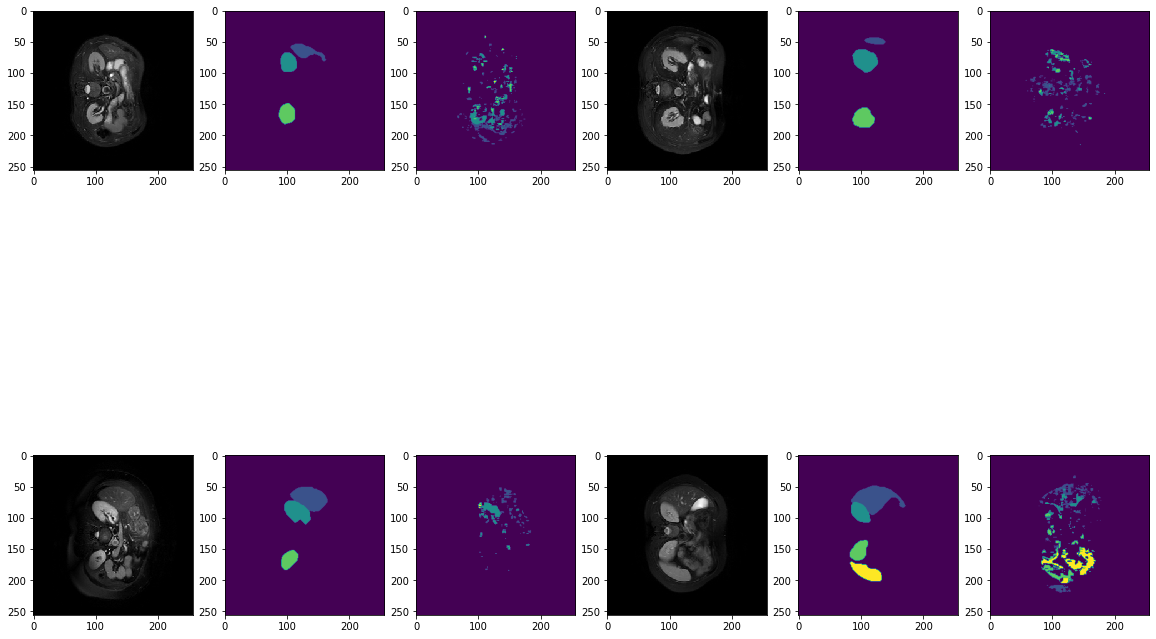

In [27]:
slice_1, slice_2, slice_3, slice_4 = 13,13,13,13

slice_im_t1 = image_test_1.get_fdata()[:,:,slice_1]
slice_im_t2 = image_test_2.get_fdata()[:,:,slice_2]
slice_im_t3 = image_test_3.get_fdata()[:,:,slice_3]
slice_im_t4 = image_test_4.get_fdata()[:,:,slice_4]

slice_mask_t1 = mask_test_1.get_fdata()[:,:,slice_1].astype(np.uint8)
slice_mask_t2 = mask_test_2.get_fdata()[:,:,slice_2].astype(np.uint8)
slice_mask_t3 = mask_test_3.get_fdata()[:,:,slice_3].astype(np.uint8)
slice_mask_t4 = mask_test_4.get_fdata()[:,:,slice_4].astype(np.uint8)

slice_seg_t1 = seg_t1[:,:,slice_1].astype(np.uint8)
slice_seg_t2 = seg_t2[:,:,slice_2].astype(np.uint8)
slice_seg_t3 = seg_t3[:,:,slice_3].astype(np.uint8)
slice_seg_t4 = seg_t4[:,:,slice_4].astype(np.uint8)

plt.figure(figsize=(20, 15))
plt.subplot(2, 6, 1)
plt.imshow(slice_im_t1, cmap='gray', interpolation='nearest')
plt.subplot(2, 6, 2)
plt.imshow(slice_mask_t1,vmin=0,vmax=4)
plt.subplot(2, 6, 3)
plt.imshow(slice_seg_t1,vmin=0,vmax=4)
plt.subplot(2, 6, 4)
plt.imshow(slice_im_t2, cmap='gray', interpolation='nearest')
plt.subplot(2, 6, 5)
plt.imshow(slice_mask_t2,vmin=0,vmax=4)
plt.subplot(2, 6, 6)
plt.imshow(slice_seg_t2,vmin=0,vmax=4)
plt.subplot(2, 6, 7)
plt.imshow(slice_im_t3, cmap='gray', interpolation='nearest')
plt.subplot(2, 6, 8)
plt.imshow(slice_mask_t3,vmin=0,vmax=4)
plt.subplot(2, 6, 9)
plt.imshow(slice_seg_t3,vmin=0,vmax=4)
plt.subplot(2, 6, 10)
plt.imshow(slice_im_t4, cmap='gray', interpolation='nearest')
plt.subplot(2, 6, 11)
plt.imshow(slice_mask_t4,vmin=0,vmax=4)
plt.subplot(2, 6, 12)
plt.imshow(slice_seg_t4,vmin=0,vmax=4)
plt.show()

### 3 - Evaluation

Le code fourni ci-dessous permets de calculer le score Dice. 

In [22]:
def compute_dice(res, gt, label): 
    A = gt == label
    B = res == label    
    TP = len(np.nonzero(A*B)[0])
    FN = len(np.nonzero(A*(~B))[0])
    FP = len(np.nonzero((~A)*B)[0])
    DICE = 0
    if (FP+2*TP+FN) != 0:
        DICE = float(2)*TP/(FP+2*TP+FN)
    return DICE*100

In [23]:
def compute_dice_exam(seg, mask):
    dice_liver = compute_dice(seg, mask, 1)
    dice_rkidney = compute_dice(seg, mask, 2)
    dice_lkidney = compute_dice(seg, mask, 3)
    dice_spleen = compute_dice(seg, mask, 4)
    return dice_liver, dice_rkidney, dice_lkidney, dice_spleen

*Les scores Dice pour les images de l'ensemble d'entraînement (13 et 19)*

In [24]:
print(compute_dice_exam(seg_1, mask_1.get_fdata()))
print(compute_dice_exam(seg_2, mask_2.get_fdata()))

(99.94239795598291, 99.85328023475162, 99.79906229068989, 99.79870658272303)
(99.93517368051428, 99.82166740971913, 99.73523235643202, 99.84041076880378)


Pour le challenge, vous serez amené à fournir les scores Dices obtenus pour chaque organe sur les données de test.

In [28]:
print(compute_dice_exam(seg_t1, mask_test_1.get_fdata()))
print(compute_dice_exam(seg_t2, mask_test_2.get_fdata()))
print(compute_dice_exam(seg_t3, mask_test_3.get_fdata()))
print(compute_dice_exam(seg_t4, mask_test_4.get_fdata()))

(37.16191711268147, 9.559925919393244, 12.241653418124006, 30.488250334835016)
(39.42072306542634, 23.88133498145859, 10.519905610108852, 36.50101714617844)
(46.647363693674095, 21.552176192973256, 11.84070324986681, 42.897990726429676)
(24.891084034200777, 6.837912825561622, 9.069526766393828, 4.845700416088765)
